In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader

In [2]:
# Import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# Organize the data

# Convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# Transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [3]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
batch_size = 64
# int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
# How big should these batches be??
test_loader = DataLoader(dataset=test_data, batch_size=test_data.tensors[0].shape[0])

#  Function that creates the ANN model

In [4]:
def create_a_new_model(L2_lambda):
  # Model architecture
  ANN_iris = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
  )

  # Loss Function
  loss_func = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = torch.optim.SGD(params=ANN_iris.parameters(), lr=0.005, weight_decay=L2_lambda)

  return ANN_iris, loss_func, optimizer

In [8]:
# Training parameter
num_epochs = 1000

# Note: this time, the model, lossfun, and optimizer are inputs into the function!
def train_the_model(ANN_iris, loss_func, optimizer):

  # Initialize accuracies as empties (not storing losses here)
  train_acc = []
  test_acc = []
  losses = []

  # Loop over epochs
  for epoch_i in range(num_epochs):

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = ANN_iris(X)
      loss = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy
    train_acc.append(np.mean(batch_acc))
    losses.append(np.mean(batch_loss))
    
    # Test accuracy
    # Switch training off, not implement any dropout
    ANN_iris.eval()
    # Extract x,y from test dataloader
    X, y = next(iter(test_loader))
    y_hat = ANN_iris(X)
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

    ANN_iris.train()
  
  # Function output
  return train_acc, test_acc, losses

In [9]:
# Create a model
L2_lambda = 0.01
ANN_iris, loss_func, optimizer = create_a_new_model(L2_lambda=L2_lambda)

# Train the model
train_acc, test_acc, losses = train_the_model(ANN_iris=ANN_iris, loss_func=loss_func, optimizer=optimizer)

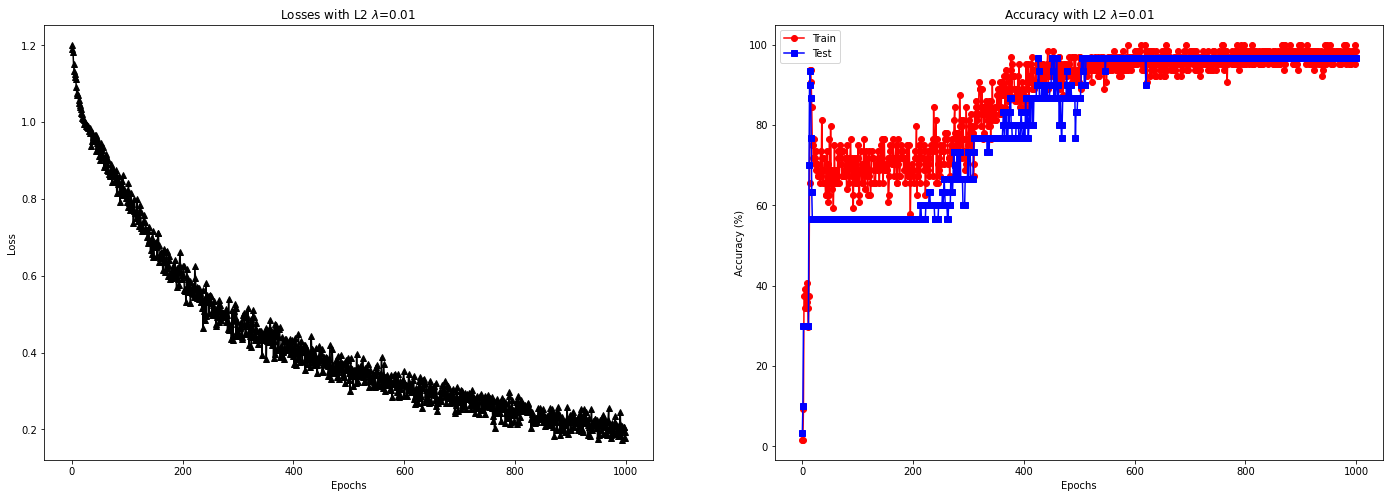

In [15]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2_lambda))

ax[1].plot(train_acc,'ro-')
ax[1].plot(test_acc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2_lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [16]:
# Create a 1D smoothing filter
def smooth(x, k):
  return np.convolve(a=x, v=np.ones(k) / k, mode='same')

# The experiment

In [17]:
# Range of L2 regularization amounts
L2_lambdas = np.linspace(start=0, stop=0.1, num=10)

# Initialize output results matrices
accuracy_results_train = np.zeros(shape=(num_epochs, len(L2_lambdas)))
accuracy_results_test = np.zeros(shape=(num_epochs, len(L2_lambdas)))

# Loop over batch sizes
for L2_lambda_i in range(len(L2_lambdas)):

  # Create and train a model
  ANN_iris, loss_func, optimizer = create_a_new_model(L2_lambda=L2_lambdas[L2_lambda_i])
  train_acc, test_acc, losses = train_the_model(ANN_iris=ANN_iris, loss_func=loss_func, optimizer=optimizer)
  
  # Store data
  accuracy_results_train[:, L2_lambda_i] = smooth(train_acc, k=10)
  accuracy_results_test[:, L2_lambda_i] = smooth(test_acc, k=10)

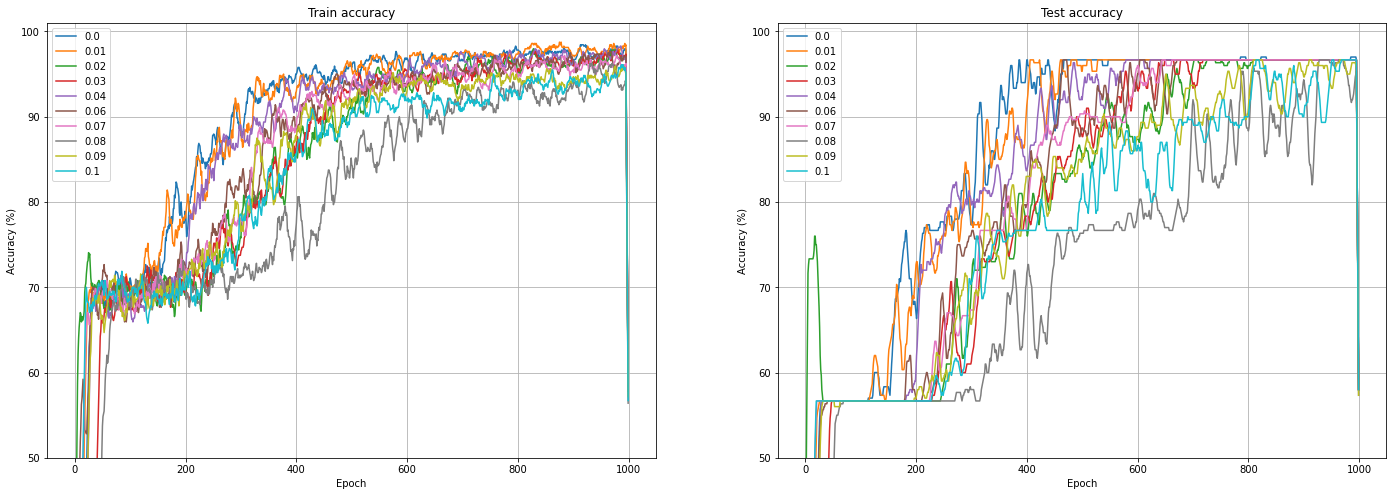

In [21]:
# Plot some results
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ax[0].plot(accuracy_results_train)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Test accuracy')

# Make the legend easier to read
leg_labels = [np.round(a=i, decimals=2) for i in L2_lambdas]

# Common features
for i in range(2):
  ax[i].legend(leg_labels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

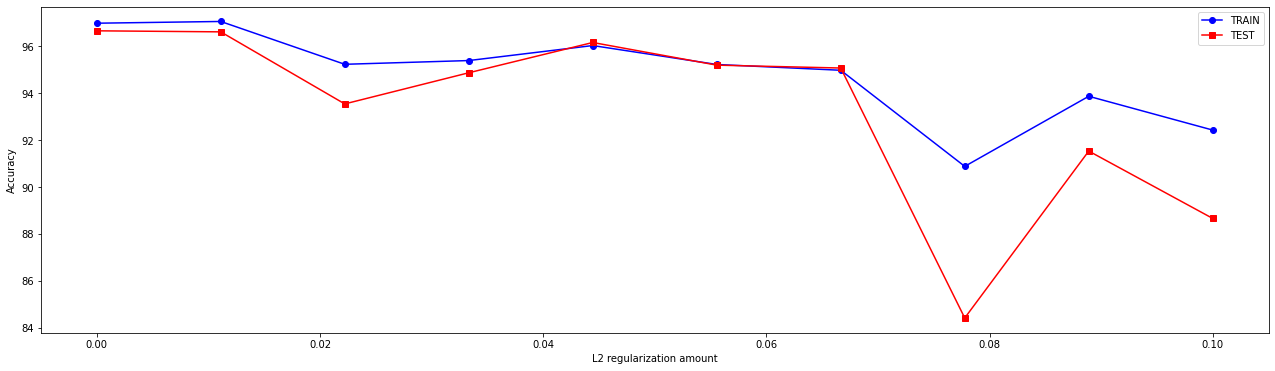

In [27]:
# Show average accuracy by L2 rate

# Average only some epochs
epoch_range = [500, 950]
plt.figure(figsize=(22, 6))
plt.plot(L2_lambdas, 
        np.mean(accuracy_results_train[epoch_range[0]:epoch_range[1], :], axis=0),
        'bo-', label='TRAIN')

plt.plot(L2_lambdas, 
        np.mean(accuracy_results_test[epoch_range[0]:epoch_range[1], :], axis=0),
        'rs-', label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Additional explorations
1) In general, regularization tends to benefit large, complex models, and has less impact (and sometimes even a negative
   impact) on smaller or simpler model architectures. Modify the model architecture to have three hidden layers, and
   see whether that changes the effect of L2 regularization on performance. (You might want to increase the number of 
   epochs.)

2) Multiple regularization methods can be combined. Add 15% dropout to the hidden layer(s) and see how that affects
   the model's performance. 